In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project 1

In this project we will use a Gibbs' sampler for inferring clonal tree in cancer with simultaneous cell-to-clone mapping.

During tumour evolution after a founding event, its cells can acquire further mutations as they proliferate. Some of those gained mutations, so called driver mutations, can provide advantages to their carriers f.e. helping them escape the tumour suppression mechanisms. Populations of cells carrying the same mutations are called **clones**.

Let's say we have a tissue in which we expect to find a number $K=2$ of clones and we have a number $N=3$ of positions in the genome with possible mutations. If clone $1$ has only the first position mutated and clone $2$ has all positions mutated, we can describe their genotypes with a $N \times K$ matrix $\textbf C$:
$$\textbf C = \left[\begin{matrix}1 & 1 \\ 0 & 1 \\ 0 & 1\end{matrix}\right].$$

We can see, that $C_{i,k}=1$ if clone $k$ has a mutation at position $i$, 0 otherwise.

We will describe the clone to which a cell $j$ belongs with $I_j$.

Now let's say we observe reads in the RNA of a cell $j$ coming from one of these positions, say $i$. If the cell $j$ came from a clone that has a mutation at that position $i$ ($C_{i, I_j} = 1$), we expect a read to be mutated with some probability $\theta_1$. However, if a cell came from a clone that is not mutated at that position ($C_{i,I_j}=0$), we can still in rare cases observe a mutation, f.e. due to technical errors of sequencing RNA -- for that we will use a (small) probability $\theta_0$.

We will denote the mutated observations of position $i$ in cell $j$ with $A_{i,j}$ and the total number of observations of position $i$ in that cell as $D_{i,j}$. Through a sequencing experiment of cells we can get matrices **A** and **D**; but of course we have no knowledge of what the genotypes of the clones are or which cell should be assigned to which clone.

In this project we will come up with a procedure to reconstruct those hidden genotypes **C** and the cell-to-clone assignment **I**. Additionaly, we will try to also model $\theta_1$ and $\theta_0$.

## Model summary

We have indices:

- $i = 1,...,N$: mutation positions
- $k = 1,...,K$: clones
- $j = 1,...,M$: cells in the sample

We have observed variables:

- matrix $\textbf A$, where $A_{i,j}$ is the observed mutation count at position $i$ in cell $j$.
- matrix $\textbf D$, where $D_{i,j}$ is the total count of observed position $i$ in cell $j$.

We have latent variables:

- matrix $\textbf C$, where $C_{i,k}$ is $1$ if clone $k$ has a mutation at position $i$, 0 otherwise.
- vector $\textbf I$, where $I_j = 1,..., K$ is the clone of origin of cell $j$.
- $\theta_1$, which is the probability of an observed read being mutated on a position that is mutated in a cell.
- $\theta_0$, which is the probability of an observed read being mutated on a position that is not mutated in a cell.

We have priors parameters:

- $a_1, b_1$: parameters of the Beta prior on $\theta_1$.
- $a_0, b_0$: parameters of the Beta prior on $\theta_0$.

Assume $C$ and $I$ have a uniform prior on each position.

# Task 1 (1 pt.)

Create a BN using the variables above. Its total probability should factorise as:
$$\mathbb P( \textbf C, \textbf A, \textbf D, \textbf I, \theta_0, \theta_1) = \mathbb P(\textbf C)\cdot \mathbb P(\textbf D) \cdot \mathbb P (\textbf I) \cdot \mathbb P( \theta_1 ) \cdot \mathbb P( \theta_0 ) \cdot \mathbb P(\textbf A | \textbf D, \textbf C, \textbf I, \theta_0, \theta_1)$$

If you have an idea for a BN that factorises in a different way, please consult it with me.

![alt text](graf.png "Logo Title Text 1")

# Task 2 (1 pt.)

Assume mutation observations across cells and positions are conditionally independent given $\textbf D, \textbf C, \textbf I, \theta_0, \theta_1$. Use this to factorise $\mathbb P(\textbf A | \textbf D, \textbf C, \textbf I, \theta_0, \theta_1)$ over cells and positions.

What is then $\mathbb P( A_{i,j} | D_{i,j}, \textbf C, I_j, \theta_0, \theta_1)$?

Hints:
- $A_{i,j}$ are those from $D_{i,j}$ that are mutated.
- Which $C$ does $A_{i,j}$ depend on in this situation?

$\mathbb P(\textbf A | \textbf D, \textbf C, \textbf I, \theta_0, \theta_1) = \prod\limits_{i,j} \mathbb P( A_{i,j} | D_{i,j}, \textbf C, I_j, \theta_0, \theta_1) $

The probability $\mathbb{P}(A_{i,j} | D_{i,j}, \textbf{C}, I_j, \theta_0, \theta_1)$ can now be easily calculated given the interpretation of the parameters:

- $\theta_0$ = $\mathbb{P}(\text{observed mutation | no cell mutation})$ and $\theta_1$ = $\mathbb{P}(\text{observed mutation | cell mutation})$,
- $A_{i,j}$ is the number of observed mutations from $D_{i,j}$ observed reads,
- $I_j$ - information about which clone the j-th cell belongs to,
- $C_{ik}$ - whether the k-th clone has a mutation at the i-th position {0,1}.

Applying reasoning consistent with the Bernoulli scheme for two possible situations ($C_{i,I_j}=0$ considering $\theta_0$ or $C_{i,I_j}=1$ considering $\theta_1$), we obtain:

$\mathbb P( A_{i,j} | D_{i,j}, \textbf C_{i,I_j} = 0, I_j, \theta_0, \theta_1) = {D_{i,j} \choose A_{i,j}}\theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}}$

$\mathbb P( A_{i,j} | D_{i,j}, \textbf C_{i,I_j} = 1, I_j, \theta_0, \theta_1) = {D_{i,j} \choose A_{i,j}}\theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}}$

$\mathbb P( A_{i,j} | D_{i,j}, \textbf C_{i,I_j}, I_j, \theta_0, \theta_1) = {D_{i,j} \choose A_{i,j}}\left(\theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}}(1-C_{i,I_j})+\theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}}C_{i,I_j}\right)$

# Task 3 (3 pt.)

Using the Bayes' formula find:

- $\mathbb P( C_{i,k}|MB(C))$,
- $\mathbb P( I_{j}|MB(I))$,
- $\mathbb P( \theta_0 | MB(\theta_0) )$,
- $\mathbb P( \theta_1 | MB(\theta_1) )$,

where MB is the Markov blanket of a variable.

Which of these have to be computed directly to sample from them? Transform them to log-probabilties, which you will use for numerical stability.

Looking at the posteriors of $\theta_0$ and $\theta_1$ can you justify the use of the Beta priors on each of them?




Reminder: Markov Blanket - in a Bayesian network, the Markov blanket of a node consists of its parents, children, and children's parents.
For the considered network, these will be all nodes except for the one whose Markov blanket we are considering.

### $\mathbb P( C_{i,k}|MB(C))$

$P(C_{i,k}) = P(C_{i,k} = 1) = P(C_{i,k} = 0) = \frac{1}{2}$ 

$\mathbb P( C_{i,k}|MB(C)) = \mathbb P( C_{i,k} |A, D, I, \theta_0, \theta_1) = \frac{\mathbb P( C_{i,k}, A, D, I, \theta_0, \theta_1)}{\mathbb P(A, D, I, \theta_0, \theta_1)} = \frac{\mathbb P(A| C_{i,k}, D, I, \theta_0, \theta_1)\mathbb P(C_{i,k})\mathbb P(D)\mathbb P(I)\mathbb P(\theta_0)\mathbb P(\theta_1)}{\mathbb P(A, D, I, \theta_0, \theta_1)} \propto \mathbb P(C_{i,k}) \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k}, D_{i,j}, I_{j}=k, \theta_0, \theta_1)$ 

$\mathbb P( C_{i,k} |A, D, I, \theta_0, \theta_1) \propto \mathbb P(C_{i,k}) \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k}, D_{i,j}, I_{j}=k, \theta_0, \theta_1) \propto \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k}, D_{i,j}, I_{j}=k, \theta_0, \theta_1)$

Let now:

$N_{i,k} = \sum\limits_{j, I_j = k} A_{i,j}$

$M_{i,k} = \sum\limits_{j, I_j = k} D_{i,j}-A_{i,j} = \sum\limits_{j, I_j = k} B_{i,j}$


$\mathbb P( C_{i,k} = 1 |A, D, I, \theta_0, \theta_1) \propto \mathbb P(C_{i,k}=1) \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k} = 1, D_{i,j}, I_{j}=k, \theta_0, \theta_1) \propto \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k} = 1, D_{i,j}, I_{j}=k, \theta_0, \theta_1)\propto \prod\limits_{j, I_j = k} \theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}} = \theta_1^{N_{i,k}}(1-\theta_1)^{M_{i,k}}$


$\mathbb P( C_{i,k} = 0 |A, D, I, \theta_0, \theta_1) \propto \mathbb P(C_{i,k} = 0) \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k} = 0, D_{i,j}, I_{j}=k, \theta_0, \theta_1) \propto \prod\limits_{j, I_j = k} \mathbb P(A_{i,j}| C_{i,k} = 0, D_{i,j}, I_{j}=k, \theta_0, \theta_1) \propto \prod\limits_{j, I_j = k} \theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}} = \theta_0^{N_{i,k}}(1-\theta_0)^{M_{i,k}}$

$\mathbb P( C_{i,k} |A, D, I, \theta_0, \theta_1) \propto \theta_0^{N_{i,k}}(1-\theta_0)^{M_{i,k}}(1-C_{i,k}) + \theta_1^{N_{i,k}}(1-\theta_1)^{M_{i,k}}C_{i,k}$

### $\mathbb P( I_{j}|MB(I))$

$P(I_{j}) = P(I_{j} = k) = \frac{1}{K}$ 

$\mathbb P( I_{j}|MB(I)) = \mathbb P( I_{j} |A, D, C, \theta_0, \theta_1) = \frac{\mathbb P( I_{j}, A, D, C, \theta_0, \theta_1)}{\mathbb P(A, D, C, \theta_0, \theta_1)} \propto \mathbb P(I_j) \prod\limits_{i} \mathbb P(A_{i,j} | I_{j}, D_{i,j}, C_{i, I_j}, \theta_0, \theta_1) \propto \prod\limits_{i} \mathbb P(A_{i,j} | I_{j}, D_{i,j}, C_{i, I_j}, \theta_0, \theta_1)$

Let now:

$AL0_j = \sum \limits_{i, C_{i,I_j} = 0} A_{i,j}$

$BL0_j = \sum \limits_{i, C_{i,I_j} = 0} D_{i,j}-A_{i,j} = \sum\limits_{i, C_{I_j} = 0} B_{i,j}$

$AL1_j = \sum \limits_{i, C_{i,I_j} = 1} A_{i,j}$

$BL1_j = \sum \limits_{i, C_{i,I_j} = 1} D_{i,j}-A_{i,j} = \sum\limits_{i, C_{I_j} = 1} B_{i,j}$

$\mathbb P( I_{j} |A, D, C, \theta_0, \theta_1) \propto \mathbb P(I_j) \prod\limits_{i} \mathbb P(A_{i,j} | I_{j}, D_{i,j}, C_{i, I_j}, \theta_0, \theta_1) \propto \prod \limits_{i} \mathbb P(A_{i,j} | I_{j}, D_{i,j}, C_{i, I_j}, \theta_0, \theta_1) \propto \prod \limits_{i} \theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}}(1-C_{i,I_j})+\theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}}C_{i,I_j}$

$\mathbb P( I_{j} |A, D, C, \theta_0, \theta_1) \propto \theta_0^{AL0_j}(1-\theta_0)^{BL0_j} \cdot \theta_1^{AL1_j}(1-\theta_1)^{BL1_j}$

### $\mathbb P( \theta_0 | MB(\theta_0) )$
$\mathbb P( \theta_0 | MB(\theta_0) ) = \mathbb P( \theta_0 |A, D, I, C, \theta_1) = \frac{\mathbb P(A, D, I, C, \theta_0, \theta_1)}{\mathbb P(A, D, I, C, \theta_1)} = \frac{\mathbb P( A|D, I, C, \theta_0, \theta_1)\mathbb P(C) \mathbb P(D) \mathbb P (I) \mathbb P( \theta_1 ) \mathbb P( \theta_0 )}{\mathbb P(A, D, I, C, \theta_1)} \propto \mathbb P( A|D, I, C, \theta_0, \theta_1) \mathbb P( \theta_0 )$

$\mathbb P( \theta_0 |A, D, I, C, \theta_1) \propto \mathbb P( \theta_0 ) \prod\limits_{i,j, C_{i,I_j}=0} \mathbb P(A_{i,j} | \theta_0, D_{i,j}, I_{j}, C_{i,I_j}=0, \theta_1) \propto \mathbb P( \theta_0 ) \prod\limits_{i,j, C_{i,I_j}=0} \theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}} =  \mathbb P( \theta_0 ) \cdot \theta_0^{\sum \limits_{j}AL0_j}(1-\theta_0)^{\sum \limits_{j} BL0_j} \propto \text{Beta}\left(a_0 + \sum \limits_{j}AL0_j, b_0 + \sum \limits_{j} BL0_j\right)$ 

### $\mathbb P( \theta_1 | MB(\theta_1) )$

$\mathbb P( \theta_1 | MB(\theta_1) ) = \mathbb P( \theta_1 |A, D, I, C, \theta_0) = \frac{\mathbb P(A, D, I, C, \theta_0, \theta_1)}{\mathbb P(A, D, I, C, \theta_0)} = \frac{\mathbb P( A|D, I, C, \theta_0, \theta_1)\mathbb P(C) \mathbb P(D) \mathbb P (I) \mathbb P( \theta_1 ) \mathbb P( \theta_0 )}{\mathbb P(A, D, I, C, \theta_0)} \propto \mathbb P( A|D, I, C, \theta_0, \theta_1) \mathbb P( \theta_1 )$

$\mathbb P( \theta_1 |A, D, I, C, \theta_0) \propto \mathbb P( \theta_1 ) \prod\limits_{i,j, C_{i,I_j}=1} \mathbb P(A_{i,j} | \theta_0, D_{i,j}, I_{j}, C_{i,I_j}=1, \theta_1) \propto \mathbb P( \theta_1 ) \prod\limits_{i,j, C_{i,I_j}=1} \theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}} =  \mathbb P( \theta_1 ) \cdot \theta_1^{\sum \limits_{j}AL1_j}(1-\theta_1)^{\sum \limits_{j} BL1_j} \propto \text{Beta}\left(a_1 + \sum \limits_{j}AL1_j, b_1 + \sum \limits_{j} BL1_j\right)$ 

We sample the posteriors of theta from the appropriate Beta distributions - the likelihood is proportional to the binomial distribution, so multiplying by the Beta prior gives the Beta posterior. We call such priors conjugate priors. We need to calculate the posteriors of $C_{i,k}$ and $I_{j}$ directly:

$\log \mathbb P( C_{i,k} = 0 |A, D, I, \theta_0, \theta_1) \propto \sum\limits_{j, I_j = k} \log(\theta_0^{A_{i,j}}(1-\theta_0)^{D_{i,j}-A_{i,j}}) = N_{i,k}\log \theta_0 + M_{i,k}\log(1-\theta_0)$

$\log \mathbb P( C_{i,k} = 1 |A, D, I, \theta_0, \theta_1) \propto \sum\limits_{j, I_j = k} \log(\theta_1^{A_{i,j}}(1-\theta_1)^{D_{i,j}-A_{i,j}}) = N_{i,k}\log \theta_1 + M_{i,k}\log(1-\theta_1)$

$\log \mathbb P( C_{i,k} |A, D, I, \theta_0, \theta_1) \propto N_{i,k}\log \theta_0 + M_{i,k}\log(1-\theta_0) (1-C_{i,k})+ N_{i,k}\log \theta_1 + M_{i,k}\log(1-\theta_1)C_{i,k}$

$\log \mathbb P( I_{j} |A, D, C, \theta_0, \theta_1) \propto AL1_{j}\log\theta_1+BL1_j \log(1-\theta_1) + AL0_j\log\theta_0+ BL0_j\log(1-\theta_0)$

# Gibbs' sampling

We want to find the posterior distributions for the $\textbf{C, I}, \theta_1, \theta_0$ variables, given our observations of $\textbf A, \textbf D$. Since direct calculation is infeasible, we will use a Gibbs' sampler to approximate them.

In a Gibbs' sampler procedure we will:
- Initialise the latent variables ($\textbf{C, I}, \theta_1, \theta_0$) using their prior distributions.
- Then in each iteration:
  - go over the latent variables in a loop, picking for each of them a new value using its conditional distribution (the one you derived above).
  - in the conditional distribution you should condition on the latest samples of variables you have.
  - before beginning a new iteration calculate the log-likelihood of the data given the current values of latent variables in the model.
- Stop after reaching a maximum number of iterations. Return the samples for the latent variables and the log-likelihood across iterations.

The sampled values of latent variables approximate their true posterior distribution in the model.

More on the Gibbs' sampling can be found on the [old faithful](https://en.wikipedia.org/wiki/Gibbs_sampling).



# Task 4 (5 pt.)

Implement a Gibbs' sampler for your BN. You can use the skeleton below. Please use log-probabilities in calculations.

Bonus 2 pt. for not iterating inside the main iteration loop -- will be counted towards lab points if total exceeds 15 pt.

In [2]:
from torch.distributions import Beta, Categorical, Bernoulli

def run_gibbs(A, D, K, theta0_prior=(100, 9900), theta1_prior=(4900, 5100), max_iter=1000):
  #numbers of positions and cells
  N, M = A.size()

  #numbers of reference reads in cells (should be helpful)
  B = D - A

  a0, b0 = theta0_prior
  a1, b1 = theta1_prior

  #prepare for sampling
  I_all = torch.empty( (max_iter, M) )
  C_all = torch.empty( (max_iter, N, K) )
  theta0_all = torch.empty( (max_iter) )
  theta1_all = torch.empty( (max_iter) )

  logLikelihood_all = torch.empty( (max_iter) )

  #pick the first sample from the prior distributions of the latent variables
  I_all[0,] = Categorical(torch.ones(K)).sample((M,)) #random assignment from an uninformative prior
  C_all[0,] = Bernoulli(1/2).sample((N,K)) #random genotypes from uninformative prior
  theta0_all[0,] = Beta(a0, b0).sample((1,)) #theta0 from Beta prior with parameters a0, b0
  theta1_all[0,] = Beta(a1, b1).sample((1,)) #theta1 from Beta prior with parameters a1, b1

  #matrix with cells of type t0^{A_{i,j}}(1-t0)^{B_{i,j}}(1-C_{i,I_j})
  logLike0 = (A*theta0_all[0].log() + B*(1-theta0_all[0]).log()) * (1 - C_all[0].index_select(1, I_all[0].int())) 

  #matrix with cells of type t1^{A_{i,j}}(1-t1)^{B_{i,j}}(1-C_{i,I_j})
  logLike1 = (A*theta1_all[0].log() + B*(1-theta1_all[0]).log()) * C_all[0].index_select(1, I_all[0].int())

  #likelihood of cells with this initialisation
  logLikelihood_all[0,] = (logLike0 + logLike1).sum()
  
  #main iteration loop
  for it in range(1, max_iter):
    t0, t1 = theta0_all[it-1,], theta1_all[it-1,]

    #sample I
    #M x K matrix, for each cell 1-M its likelihood in each clone 1-K
    cell_loglikelihoods = torch.empty( (M, K) )

    #############################################

    AL0 = A.transpose(0,1) @ (1 - C_all[it-1])
    AL1 = A.transpose(0,1) @ C_all[it-1]
    BL0 = B.transpose(0,1) @ (1 - C_all[it-1])
    BL1 = B.transpose(0,1) @ C_all[it-1]

    #############################################
    
    cell_loglikelihoods = t0.log()*AL0+(1-t0).log()*BL0+t1.log()*AL1+(1-t1).log()*BL1
    
    I_all[it,] = Categorical( logits=cell_loglikelihoods ).sample( (1,) )

    #sample C
    #easy way to get matrix of cell-clone assignment (hint: use it somewhere)
    cell_to_clone = torch.zeros((M,K))
    cell_to_clone[ torch.arange(M), I_all[it,].int() ] = 1

    N_all = A @ cell_to_clone
    M_all = B @ cell_to_clone

    #N x K matrix, for i,k the difference of log-likelihoods for C_{i,k}=0 and C_{i,k}=1 (in that order)
    log_odds_ratio = t0.log() * N_all + (1-t0).log()* M_all - t1.log()*N_all - (1-t1).log()* M_all

    log_odds_ratio = torch.clamp( log_odds_ratio, min=-50, max=50 )

    C_probs = 1 / (1 + log_odds_ratio.exp()) #N x K matrix, for i,k the probabiliity C_{i,k}=1

    C_all[it,] = Bernoulli( probs=C_probs ).sample( (1,) )

    #sample theta0
    # Here, in order to avoid recalculating AL0, AL1, BL0, BL1, I use matrices N, M and filter them based on C.
    theta0_all[it,] = Beta(a0 + (N_all*(1-C_all[it])).sum(), b0 + (M_all*(1-C_all[it])).sum()).sample((1,))

    #sample theta1
    theta1_all[it,] = Beta(a1 + (N_all*C_all[it]).sum(), b1 +(M_all*C_all[it]).sum()).sample((1,))

    #matrix with cells of type t0^{A_{i,j}}(1-t0)^{B_{i,j}}(1-C_{i,I_j})
    logLike_mat0 = (A*theta0_all[it].log() + B*(1-theta0_all[it]).log()) * (1 - C_all[it].index_select(1, I_all[it].int())) 

    #matrix with cells of type t1^{A_{i,j}}(1-t1)^{B_{i,j}}(1-C_{i,I_j})
    logLike_mat1 = (A*theta1_all[it].log() + B*(1-theta1_all[it]).log()) * C_all[it].index_select(1, I_all[it].int())

    #calculate log-likelihood
    logLikelihood_all[it,] = (logLike_mat0 + logLike_mat1).sum()

  return {'C': C_all,
          'I': I_all,
          't0': theta0_all,
          't1': theta1_all,
          'logLik': logLikelihood_all}

# Task 5 (1 pt.)

You are given matrices **A** and **D**, the prior parameters on $\theta$'s, and the number of clones expected in the tissue $K=3$. The $\theta$'s prior parameters are $a_0 = 100, b_0=9900$ and $a_1=4900, b_1=5100$.

Run the Gibbs's sampler on that data for 1000 iterations, independently, three times. Save each result.

Plot the likelihoods of the three chains together. At what point does it seem to stabilise? Based on that propose a burn-in fraction of the iterations that should be discarded.

In [3]:
A = torch.load("./A.pt")
D = torch.load("./D.pt")

torch.manual_seed(89)
chains = [run_gibbs( A, D, K=3 ) for _ in range(3)]

<Axes: >

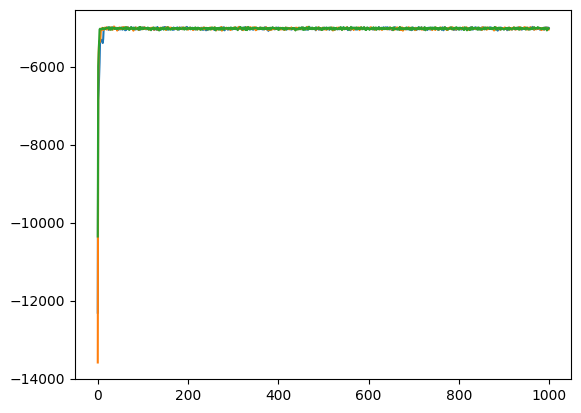

In [4]:
sns.lineplot(chains[0]['logLik'])
sns.lineplot(chains[1]['logLik'])
sns.lineplot(chains[2]['logLik'])

<Axes: >

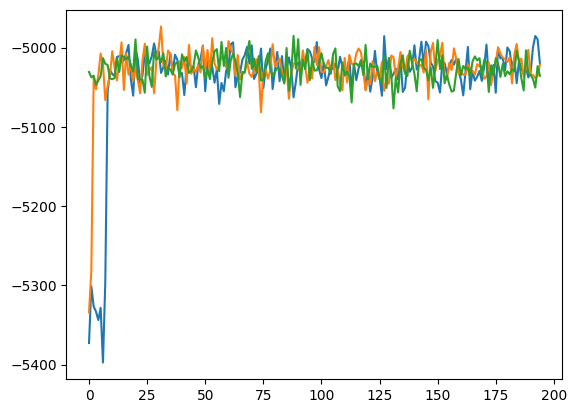

In [5]:
sns.lineplot(chains[0]['logLik'][5:200])
sns.lineplot(chains[1]['logLik'][5:200])
sns.lineplot(chains[2]['logLik'][5:200])

<Axes: >

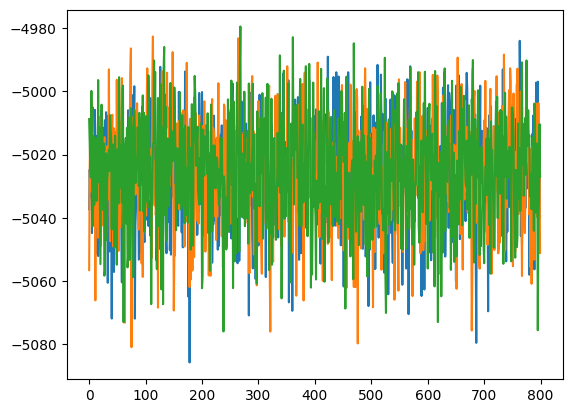

In [6]:
sns.lineplot(chains[0]['logLik'][200:])
sns.lineplot(chains[1]['logLik'][200:])
sns.lineplot(chains[2]['logLik'][200:])

All chains stabilize quite quickly, however, I will assume a burn-in equal to 20% of iterations. After 200 iterations, it is visible that the chains stabilize at the same level.

# Task 6 (2 pt.)

For each chain get the *maximum a posteriori* values of the latent variables, but only using the samples from iterations after the burn-in phase proposed above.

Which values agree between the chains? Which do not?

Now use the [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index) to compare the agreement of cell-clone assignment $\textbf{I}$ across the chains. How good does it look now? What changed?

In [7]:
from sklearn.metrics import adjusted_rand_score

burn_in = 200
keys = list(chains[0].keys())

chain1 = {k: val[burn_in:] for k, val in chains[0].items()}
chain2 = {k: val[burn_in:] for k, val in chains[1].items()}
chain3 = {k: val[burn_in:] for k, val in chains[2].items()}

# We sample the Thetas from continuous distributions, 
# #comparing modes for a finite sample doesn't make sense. 
# Instead, we will compare means for this purpose.

################################### chain 1 ######################################
map_ch1_I = chain1['I'].mode(dim=0).values 
map_ch1_C = chain1['C'].mode(dim=0).values 
mean_ch1_t0 = chain1['t0'].mean()
mean_ch1_t1 = chain1['t1'].mean()

################################### chain 2 ######################################
map_ch2_I = chain2['I'].mode(dim=0).values 
map_ch2_C = chain2['C'].mode(dim=0).values 
mean_ch2_t0 = chain2['t0'].mean()
mean_ch2_t1 = chain2['t1'].mean()

################################### chain 3 ######################################
map_ch3_I = chain3['I'].mode(dim=0).values 
map_ch3_C = chain3['C'].mode(dim=0).values 
mean_ch3_t0 = chain3['t0'].mean()
mean_ch3_t1 = chain3['t1'].mean()

################################ comparison ######################################

# When do these tensors describe the same situation?
#I -> assigning a cell to a clone (as a label), to compare this,
#     we would like to assign it to a set of mutations instead of labels
#C -> describes mutations of clones, clone = set of mutations at positions
#     when these sets of mutations are the same (regardless of clone labels)

_, K = map_ch1_C.size()
_, M = A.size()

ctc1 = torch.zeros((M,K))
ctc1[ torch.arange(M), map_ch1_I.int() ] = 1

ctc2 = torch.zeros((M,K))
ctc2[ torch.arange(M), map_ch2_I.int() ] = 1

ctc3 = torch.zeros((M,K))
ctc3[ torch.arange(M), map_ch3_I.int() ] = 1

flat1 = (ctc1@map_ch1_C.transpose(0,1)).flatten()
flat2 = (ctc2@map_ch2_C.transpose(0,1)).flatten()
flat3 = (ctc3@map_ch3_C.transpose(0,1)).flatten()

ars12 = adjusted_rand_score(flat1, flat2)
ars23 = adjusted_rand_score(flat2, flat3)
ars31 = adjusted_rand_score(flat3, flat1)

# chain1 vs chain2
print(f"\nchain1 vs chain2")
print(f"map_ch1_I agree with map_ch2_I: {torch.equal(ctc1@map_ch1_C.transpose(0,1),ctc2@map_ch2_C.transpose(0,1))}")
print(f"map_ch1_C agree with map_ch2_C: {torch.equal(map_ch1_C.unique(),map_ch2_C.unique())}")
print(f"mean_ch1_t0 vs mean_ch2_t0 : {mean_ch1_t0:3f},{mean_ch2_t0:3f}, difference: {mean_ch1_t0-mean_ch2_t0:e}")
print(f"mean_ch1_t1 vs mean_ch2_t1: {mean_ch1_t1:3f},{mean_ch2_t1:3f}, difference: {mean_ch1_t1-mean_ch2_t1:e}")
print(f"ARS12: {ars12}")

# chain2 vs chain3
print(f"\nchain2 vs chain3")
print(f"map_ch2_I agree with map_ch3_I: {torch.equal(ctc2@map_ch2_C.transpose(0,1),ctc3@map_ch3_C.transpose(0,1))}")
print(f"map_ch2_C agree with map_ch3_C: {torch.equal(map_ch2_C.unique(),map_ch3_C.unique())}")
print(f"mean_ch2_t0 vs mean_ch3_t0: {mean_ch2_t0:3f},{mean_ch3_t0:3f}, difference: {mean_ch2_t0-mean_ch3_t0:e}")
print(f"mean_ch2_t1 vs mean_ch3_t1: {mean_ch2_t1:3f},{mean_ch3_t1:3f}, difference: {mean_ch1_t1-mean_ch2_t1:e}")
print(f"ARS23: {ars23}")

# chain3 vs chain1
print(f"\nchain3 vs chain1")
print(f"map_ch3_I agree with map_ch1_I: {torch.equal(ctc1@map_ch1_C.transpose(0,1),ctc3@map_ch3_C.transpose(0,1))}")
print(f"map_ch3_C agree with map_ch1_C: {torch.equal(map_ch1_C.unique(),map_ch3_C.unique())}")
print(f"mean_ch3_t0 vs mean_ch1_t0: {mean_ch1_t0:3f},{mean_ch3_t0:3f}, difference: {mean_ch1_t0-mean_ch3_t0:e}")
print(f"mean_ch3_t1 vs mean_ch1_t1: {mean_ch1_t1:3f},{mean_ch3_t1:3f}, difference: {mean_ch1_t1-mean_ch3_t1:e}")
print(f"ARS31: {ars31}")


chain1 vs chain2
map_ch1_I agree with map_ch2_I: False
map_ch1_C agree with map_ch2_C: True
mean_ch1_t0 vs mean_ch2_t0 : 0.010333,0.010360, difference: -2.686679e-05
mean_ch1_t1 vs mean_ch2_t1: 0.485406,0.485487, difference: -8.171797e-05
ARS12: 0.9675932335106355

chain2 vs chain3
map_ch2_I agree with map_ch3_I: False
map_ch2_C agree with map_ch3_C: True
mean_ch2_t0 vs mean_ch3_t0: 0.010360,0.010417, difference: -5.711149e-05
mean_ch2_t1 vs mean_ch3_t1: 0.485487,0.485561, difference: -8.171797e-05
ARS23: 0.9708755859747609

chain3 vs chain1
map_ch3_I agree with map_ch1_I: False
map_ch3_C agree with map_ch1_C: True
mean_ch3_t0 vs mean_ch1_t0: 0.010333,0.010417, difference: -8.397829e-05
mean_ch3_t1 vs mean_ch1_t1: 0.485406,0.485561, difference: -1.556277e-04
ARS31: 0.9649712632686864


When we check the agreement of I, it turns out that for different chains they do not describe the same situation. However, ARS indicates a high level of similarity (for seed 89 about 0.97)

# Task 7 (1 pt.)

For one chosen chain plot using seaborn.heatmap:
- The posterior probabilities of $C_{i,k} = 1$ in a $N \times K$ matrix.
- The posterior probabilities of $I_{j} = k$ in a $M \times K$ matrix.

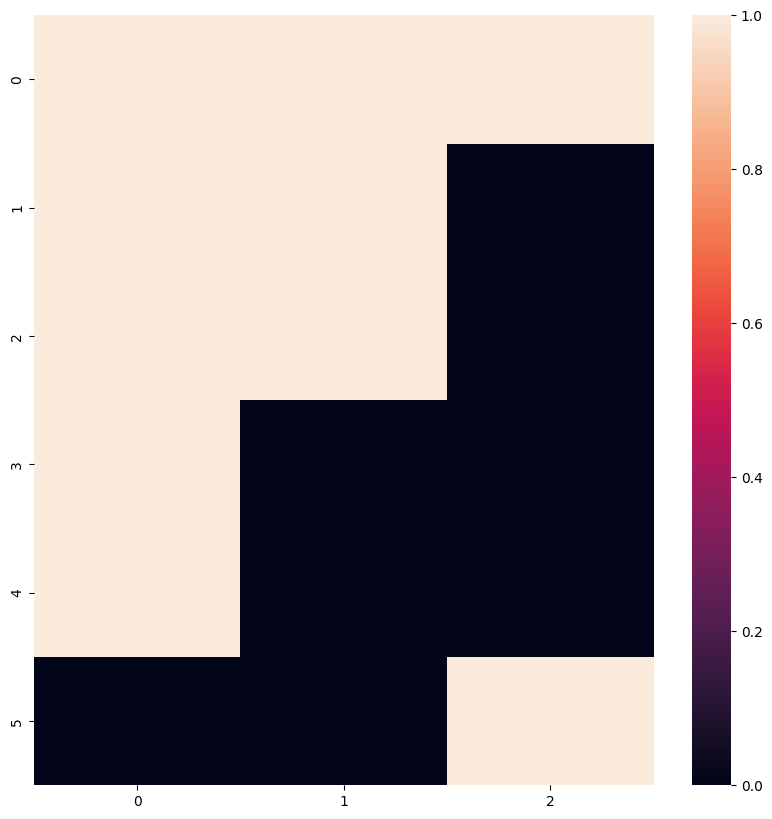

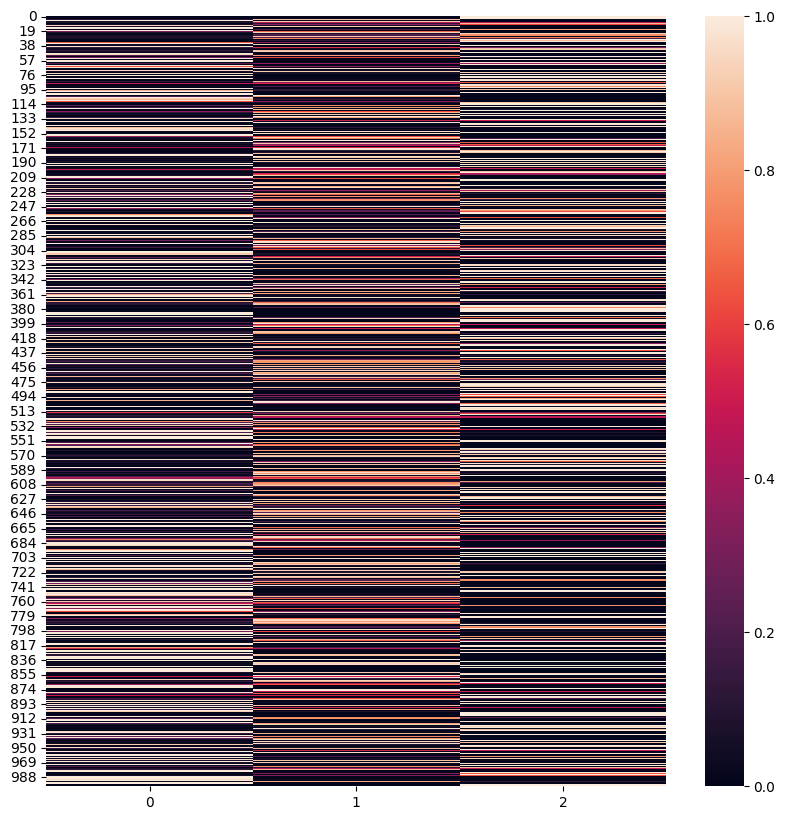

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(chain1['C'][burn_in:,].mean(dim=0))
plt.show()
plt.figure(figsize=(10, 10))
sns.heatmap((chain1['I'][burn_in:,][:,:,None]== torch.arange(3)).float().mean(dim=0))
plt.show()